In [ ]:
!python -m spacy download en_core_web_md 

     |████████████████████████████████| 96.4 MB 1.5 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051301 sha256=1816526806afb021bf484023ed6139f283338e7e4f78d5dbbdb0e68c8f99ca14
  Stored in directory: /tmp/pip-ephem-wheel-cache-qsxwzpns/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
import pandas as pd
import numpy as np
from pprint import pprint
import warnings
from textblob import TextBlob
warnings.filterwarnings("ignore",category=DeprecationWarning)
pd.set_option('display.max_colwidth', -1)  # to view entire text in any column

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys


In [ ]:
!pip install pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

from pyspark.sql.functions import col, count, countDistinct
from pyspark.sql import functions as F
spark = SparkSession \
    .builder \
    .appName("Review-Dataframe") \
    .master("local[*]")\
    .getOrCreate()

In [ ]:
# df =pd.read_csv('https://raw.githubusercontent.com/sanjeevhm/BDAProject/binary_classification/Headphone_df_processed_nlp.csv')
spark_df =  spark.read.load('Headphone_df_processed_nlp.csv',
            format="csv", sep=",", header=True,
            inferSchema="true")

In [ ]:
df = spark_df.toPandas()

In [ ]:
headphone_df=df

In [ ]:
headphone_df.head()

In [ ]:
import spacy
sp = spacy.load("en_core_web_sm")

In [ ]:
def feature_aspect_modeling(review, features):
  aspects_new = [] # tried NLTK, but the parts of speech tagging is similar to SpaCy
  review = str(review)
  doc = sp(review)
  descriptive_item = ''
  targets = []
  description = []
  #sentiment_new = []
  for token in doc:
    if token.text in features:
      targets.append(token.text)
    if token.pos_ == 'ADJ':
      added_terms = ''
      for mini_token in token.children:
        if mini_token.pos_ != 'ADV':
          continue
        added_terms += mini_token.text + ' '
      description.append(added_terms + token.text)
  for target in range(len(targets)):
    if(target <= len(description) - 1):
        description.append(description[target])
        aspects_new.append({ 'aspect': targets[target],
         'description': description[target], 'sentiment': TextBlob(description[target]).sentiment})
  return aspects_new

In [ ]:
feature_list = ["sound", "color", "cost",'condition','love','price','money','audio','quality','amount','inexpensive','amplifier','size','material','noise','package','shipping','jack','beat','control','cord','wire','mic','earbud','music']

In [ ]:
headphone_df['aspect_analysis'] = headphone_df['review_lemmatized'].apply(feature_aspect_modeling, features = feature_list)

In [ ]:
headphone_df

In [ ]:
def polarityFunc(aspectAnalysis,feature):
  for j in aspectAnalysis:
    if j['aspect'] == feature:
      return round(float(j['sentiment'][0]),2)
  

In [ ]:
for i in feature_list:
  headphone_df[i] = headphone_df['aspect_analysis'].apply(polarityFunc,feature = i)

In [ ]:
headphone_df.head()

,Unnamed: 0,product_id,product_tite,star_rating,review_headline,review_body,review_date,review_lemmatized,aspect_analysis,sound,...,package,shipping,jack,beat,control,cord,wire,mic,earbud,music
0,0,B003EM6AQE,Panasonic ErgoFit In-Ear Earbud Headphone,5,Great In-Ear Headphones!,I LOVE THESE HEADPHONES! I am totally satisfied with the sound and the fact that they stay in my ears! They are great...and I love the color of course. :),2015-08-31,love totally satisfied sound fact stay ear greatand love color course,"[{'aspect': 'love', 'description': 'totally satisfied', 'sentiment': (0.5, 1.0)}, {'aspect': 'sound', 'description': 'sound', 'sentiment': (0.4, 0.4)}, {'aspect': 'love', 'description': 'totally satisfied', 'sentiment': (0.5, 1.0)}, {'aspect': 'color', 'description': 'sound', 'sentiment': (0.4, 0.4)}]",0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,B003EM8008,Panasonic ErgoFit In-Ear Earbud Headphone,5,Good quality head phones!,"Probably the best earphones ever. Better than the Apple ones, I just wished that it had a mic on it, but these will last you a long time. Just ordered my second pair (since my first one got stolen) I had these for about 5 months and it still was in good condition before someone took it. Definitely would recommend and continue to repurchase these. Also, fast shipping too.",2015-08-31,probably good earphone ever well apple one wish mic last long time order second pair since first one get steal month still good condition someone take definitely would recommend continue repurchase also fast shipping,"[{'aspect': 'mic', 'description': 'good', 'sentiment': (0.7, 0.6000000000000001)}, {'aspect': 'condition', 'description': 'last', 'sentiment': (0.0, 0.06666666666666667)}, {'aspect': 'shipping', 'description': 'long', 'sentiment': (-0.05, 0.4)}]",NaN,...,NaN,-0.05,NaN,NaN,NaN,NaN,NaN,0.7,NaN,NaN
2,2,B003EM6AOG,Panasonic ErgoFit In-Ear Earbud Headphone,5,Not bad at all!,"Great headphones, I mean they aren't going to blow your mind or anything, but they really work perfectly for the price you pay and for what they are .. these work so nicely for me when I'm trying to do some work and need outside sounds blocked out and I just want to hear the video I'm watching or the music I'm listening to.",2015-08-31,great mean go blow mind anything really work perfectly price pay work nicely try work need outside sound block want hear video watch music listening,"[{'aspect': 'price', 'description': 'great', 'sentiment': (0.8, 0.75)}, {'aspect': 'sound', 'description': 'outside', 'sentiment': (0.0, 0.05)}, {'aspect': 'music', 'description': 'great', 'sentiment': (0.8, 0.75)}]",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8
3,3,B00E4LGVUO,Panasonic ErgoFit In-Ear Earbud Headphone,5,Five Stars,I love them for their price and quality.,2015-08-31,love price quality,[],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,B003EM8008,Panasonic ErgoFit In-Ear Earbud Headphone,5,I love these!,I love these earphones! They're very good for the price which is cheap.,2015-08-31,love earphone good price cheap,"[{'aspect': 'love', 'description': 'good', 'sentiment': (0.7, 0.6000000000000001)}, {'aspect': 'price', 'description': 'cheap', 'sentiment': (0.4, 0.7)}]",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Grouping similar columns

In [ ]:
headphone_df['sound'] = (headphone_df.fillna(0)['audio'] + headphone_df.fillna(0)['sound'] + headphone_df.fillna(0)['music'] )/3

In [ ]:
headphone_df['sound'].unique()

In [ ]:
headphone_df = headphone_df.drop(['audio','music'], axis =1)

In [ ]:
headphone_df['cost'] = (headphone_df.fillna(0)['cost'] + headphone_df.fillna(0)['money'] + headphone_df.fillna(0)['price'] + headphone_df.fillna(0)['amount'])/4

In [ ]:
headphone_df['cost'].unique()

In [ ]:
headphone_df = headphone_df.drop(['money','price','amount'], axis =1)

In [ ]:
headphone_df['wire'] = (headphone_df.fillna(0)['cord'] + headphone_df.fillna(0)['wire'])/2

In [ ]:
headphone_df = headphone_df.drop(['cord'], axis =1)

In [ ]:
list(headphone_df.columns)

['Unnamed: 0',
 'product_id',
 'product_tite',
 'star_rating',
 'review_headline',
 'review_body',
 'review_date',
 'review_lemmatized',
 'aspect_analysis',
 'sound',
 'color',
 'cost',
 'condition',
 'love',
 'quality',
 'inexpensive',
 'amplifier',
 'size',
 'material',
 'noise',
 'package',
 'shipping',
 'jack',
 'beat',
 'control',
 'wire',
 'mic',
 'earbud']

In [ ]:
headphone_df['Agg senti'] = (headphone_df.fillna(0)['sound']+ headphone_df.fillna(0)['color']+ headphone_df.fillna(0)['cost']+ headphone_df.fillna(0)['condition']+ headphone_df.fillna(0)['love']+ 
headphone_df.fillna(0)['quality']+ headphone_df.fillna(0)['inexpensive']+ headphone_df.fillna(0)['amplifier']+ headphone_df.fillna(0)['size']+ headphone_df.fillna(0)['material']+ headphone_df.fillna(0)['noise']+
headphone_df.fillna(0)['package']+ headphone_df.fillna(0)['shipping']+ headphone_df.fillna(0)['jack']+ headphone_df.fillna(0)['beat']+ headphone_df.fillna(0)['control']+ headphone_df.fillna(0)['wire']+ headphone_df.fillna(0)['mic']+ headphone_df.fillna(0)['earbud'])/19

In [ ]:
headphone_df['Agg senti binary'] = headphone_df['Agg senti'] .replace(np.nan, 0)

In [ ]:
conditions = [
    (headphone_df['Agg senti binary'] < 0.0),
    (headphone_df['Agg senti binary'] >= 0.0)
    ]
Values =[0,1]
headphone_df['Agg senti binary'] = np.select(conditions, Values)

From binary classification file

In [ ]:
conditions = [
    (headphone_df['star_rating'] < 3.0),
    (headphone_df['star_rating'] >= 3.0)
    ]
Values =[0,1]
headphone_df['star_rating binary'] = np.select(conditions, Values)

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(headphone_df['star_rating binary'],headphone_df['Agg senti binary'])

print(cf_matrix)

[[    0  1973]
 [    0 22837]]


In [ ]:
import matplotlib.pyplot as plt

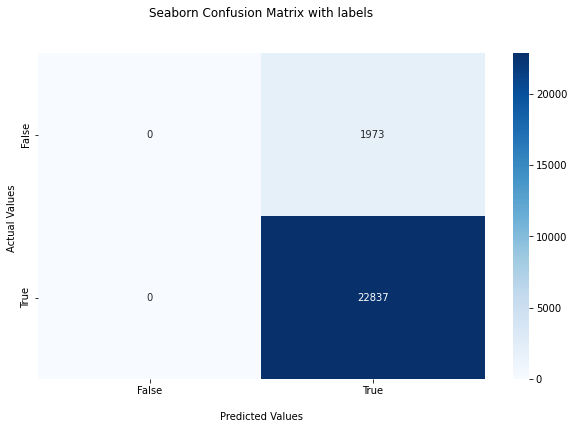

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
pd.set_option('display.float_format', lambda x: '%.6f' % x)

import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',  fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('Precision: %.3f' % precision_score(headphone_df['star_rating binary'],headphone_df['Agg senti binary']))
print('Recall: %.3f' % recall_score(headphone_df['star_rating binary'],headphone_df['Agg senti binary']))
print('Accuracy: %.3f' % accuracy_score(headphone_df['star_rating binary'],headphone_df['Agg senti binary']))
print('F1 Score: %.3f' % f1_score(headphone_df['star_rating binary'],headphone_df['Agg senti binary']))

Precision: 0.920
Recall: 1.000
Accuracy: 0.920
F1 Score: 0.959


In [ ]:
headphone_df.to_csv('final_headphone_df.csv')

In [ ]:
import datetime;
headphone_df = headphone_df.fillna(0)
headphone_df['review_date'] = pd.to_datetime(headphone_df['review_date'])
headphone_df['reviewYear'] = pd.DatetimeIndex(df['review_date']).year

In [ ]:
headphone_df['reviewYear']

0        2015
1        2015
2        2015
3        2015
4        2015
         ... 
24805    2010
24806    2010
24807    2010
24808    2010
24809    2010
Name: reviewYear, Length: 24810, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'Number of Reviews')

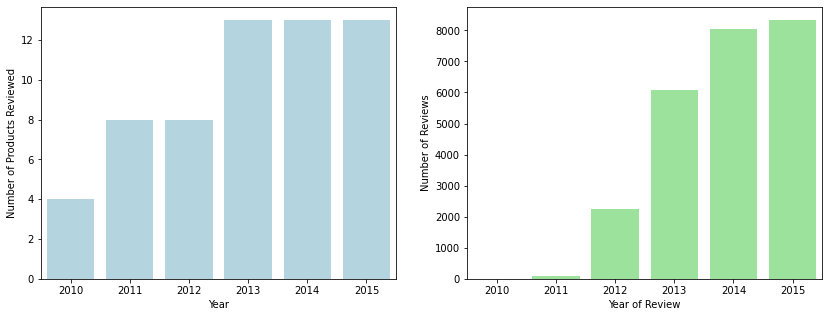

In [ ]:
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import pandas as pd
import numpy as np
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
prod_by_yr = headphone_df[['reviewYear','product_id']].drop_duplicates()
g2 = sns.countplot( x = 'reviewYear', data = prod_by_yr, color = "lightblue", ax = ax1 )
g2.set_xlabel('Year')
g2.set_ylabel('Number of Products Reviewed')

g1 = sns.countplot( x = 'reviewYear', data = headphone_df, color = "lightgreen", ax = ax2 )
g1.set_xlabel('Year of Review')
g1.set_ylabel('Number of Reviews')

In [ ]:
df_graph = headphone_df['product_id'].drop_duplicates()
df_graph= headphone_df.groupby('product_id').std().reset_index('product_id')
df_graph.values.tolist()

In [ ]:
!pip install pyam-iamc
import pyam

     |████████████████████████████████| 93 kB 1.1 MB/s 
     |████████████████████████████████| 96 kB 5.6 MB/s 
     |████████████████████████████████| 209 kB 53.3 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


<IPython.core.display.Javascript object>

In [ ]:
df = pyam.IamDataFrame(pd.DataFrame([['B003ELYQGG',
  7193.82552560851,
  0.970737497134811,
  0.33586028672003043,
  0.16567105596560588,
  0.0778466525244572,
  0.031278266016789395,
  0.15086141991324473,
  0.30151989486127745,
  0.11835757872729531,
  0.05861179469205192,
  0.24354659741896387,
  0.030752459225934337,
  0.07167740574820979,
  0.0,
  1.0301640847503803],
 ['B003ELYQHK',
  7289.518447037138,
  0.9787179081783562,
  0.3341843489052724,
  0.16421784223412136,
  0.08096162521051362,
  0.04098267524755235,
  0.1602025050081224,
  0.3023253358013799,
  0.10813922815395148,
  0.07903111628245055,
  0.2545473403764629,
  0.039430210961021825,
  0.07451477950563902,
  0.004125684985035179,
  1.0062586384185952],
 ['B003ELYQJI',
  7233.436346049488,
  1.0662305726503705,
  0.3231401183558752,
  0.1430445463499366,
  0.0836969567822899,
  0.036228265158992246,
  0.1594318435245493,
  0.2842646789111211,
  0.11436028164177638,
  0.07036894744550586,
  0.2460172244505064,
  0.05458385888489717,
  0.08062805082541578,
  0.0,
  1.009008371609487],
 ['B003EM2WAW',
  6746.050632149417,
  0.9388232299730811,
  0.3258519525209743,
  0.14942607945772374,
  0.0782772912438095,
  0.03656771332726538,
  0.18717805042569982,
  0.27421388147657594,
  0.10500361146197601,
  0.053308209259532294,
  0.23024041973972886,
  0.054417427281175844,
  0.06620830350245585,
  0.0,
  0.9296388949130885],
 ['B003EM6AOG',
  7317.363250646794,
  0.9818768304447544,
  0.32066932083916666,
  0.13371213167505472,
  0.06842181343822458,
  0.04706213779308771,
  0.14448588601871148,
  0.2857002400747898,
  0.09089620040326597,
  0.061900571202468974,
  0.23829981928940322,
  0.03669872383130656,
  0.07802094058250475,
  0.0,
  1.019881108547493],
 ['B003EM6AQE',
  7009.096687916191,
  0.9996407026490244,
  0.3322676238208017,
  0.17782164389472585,
  0.0717615500748088,
  0.033112173018381166,
  0.1923964476094867,
  0.2802849746361901,
  0.10153660731788981,
  0.05314213456170126,
  0.24271482532481162,
  0.030758747431175584,
  0.08452136867711099,
  0.0,
  0.9634139042069474],
 ['B003EM8008',
  7119.347637448929,
  1.0983057502477003,
  0.3406068321591039,
  0.04533847729892565,
  0.08756151080879397,
  0.029503815503932936,
  0.1281027713940326,
  0.29319074495498637,
  0.11391163383774355,
  0.07717785628808241,
  0.2505785278071053,
  0.04405215493820443,
  0.07571505065432739,
  0.008282949537398316,
  0.9723702000589143],
 ['B003EM800S',
  7361.302489528599,
  1.055793018039103,
  0.333834588937243,
  0.06584543083005068,
  0.08715840347456064,
  0.043903459876388426,
  0.14160367523565748,
  0.28094325025937683,
  0.09419448571198451,
  0.06984963588489371,
  0.2551323637382632,
  0.037927909522116124,
  0.06782492444198471,
  0.014871921190863686,
  1.0282271433103178],
 ['B00E4LGTVU',
  4648.587639679754,
  0.9116585333690082,
  0.32062431946658315,
  0.17686989447852666,
  0.06527533657682194,
  0.0,
  0.15365866061401603,
  0.32365994340144094,
  0.071868916185328,
  0.10441804146638922,
  0.2241470994610377,
  0.0746003846592251,
  0.0606128125356204,
  0.0,
  0.5171358072819044],
 ['B00E4LGTYC',
  4295.5163406611055,
  0.9661601197511107,
  0.349991261384065,
  0.1230660207636848,
  0.06468822361931574,
  0.0,
  0.13850932664371082,
  0.2806450610458099,
  0.11427622766041799,
  0.0933517496388008,
  0.24976857161187568,
  0.03742759613449134,
  0.09330098985127881,
  0.0,
  0.4937935667976788],
 ['B00E4LGU1Y',
  4940.243071049687,
  1.1409309080962895,
  0.37494493278326085,
  0.05578524610186687,
  0.09599829484116758,
  0.0,
  0.16773381186425138,
  0.28197800304793025,
  0.1576711715766064,
  0.0953757555432605,
  0.3048243946226122,
  0.03106854602666616,
  0.02855607898454174,
  0.0,
  0.6054495183637113],
 ['B00E4LGU32',
  4111.929575813273,
  0.9748763465495802,
  0.3176064875303062,
  0.09735354430491751,
  0.0,
  0.0,
  0.2145222331082599,
  0.27900570547616305,
  0.073945334550672,
  0.03682298471593293,
  0.2128957274292784,
  0.026696663919051372,
  0.0,
  0.0,
  0.5100752246022259],
 ['B00E4LGVUO',
  4793.1379487971935,
  1.1230433926178376,
  0.3506568644958953,
  0.032279566576494195,
  0.08048967409906378,
  0.0,
  0.11021304092481614,
  0.3000510115206507,
  0.12205842734238459,
  0.08566887983120394,
  0.23162596819134118,
  0.04758657297937671,
  0.06820650762816059,
  0.0016162704595880915,
  0.542394783679224]],
    columns=['model',
 'Unnamed: 0',
 'star_rating',
 'sound',
 'color',
 'cost',
 'condition',
 'love',
 'price',
 'money',
 'audio',
 'quality',
 'amount',
 'inexpensive',
 'amplifier',
 'reviewYear']
))
df.head()

ValueError: ignored

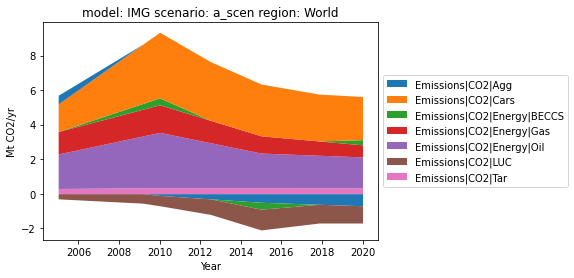

In [ ]:
df.plot.stack();